In [1]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
# datasets and models
import sys
sys.path.append("../../")
from datasets import get_cifar10
from quantize_layers import Conv2D_Q,Dense_Q,DepthwiseConv2D_Q
from models import VGG7_N
from quantize_methods import uL2Q,VecQ

Using TensorFlow backend.


# Produce a quantized model

In [2]:
x_train,y_train,x_test,y_test=get_cifar10()
vgg_like=VGG7_N(using_bn=True,
           weights_decay=0.0001,
           kq=VecQ(4),
           bq=VecQ(4),
           aq=None,
           after_activation=None,
           N=64,
           c_drop_rate=0,
           f_drop_rate=0.5)

Cifar10:  (50000, 32, 32, 3) (50000, 10) [1.0, 0.0]
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


# Fine-tuning quantized model

In [3]:
import keras
vgg_like.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(0.1),
              metrics=['acc'])
vgg_like.fit(x_train,y_train,epochs=1,batch_size=100,validation_data=(x_test,y_test))
vgg_like.evaluate(x_test,y_test,batch_size=100)

Instructions for updating:
Use tf.cast instead.
Train on 50000 samples, validate on 10000 samples
Epoch 1/1
10000/10000 [==============================] - 10s 1ms/step


[1.7883819508552552, 0.505399996638298]

# Get the integer weights

alpha=0.011290


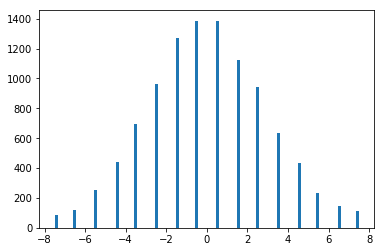

In [5]:
# Take layer 0 as an example
alpha=K.get_value(vgg_like.layers[0].kq.alpha)
integer_weights=K.get_value(vgg_like.layers[0].kq.fixed)
print("alpha=%f"%alpha)
_=plt.hist(integer_weights.reshape(-1),bins=100)